### Imports

In [ ]:
import pickle

import flax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import pandas as pd
import regina

from pachner_traversal.data_io import Dataset, Encoder
from pachner_traversal.transformer import (
    MinimalTrainState,
    Transformer,
    generate_samples,
)
from pachner_traversal.utils import data_path, set_style

set_style()

### Data

In [191]:
file_path = data_path / "input_data" / "processed" / "spheres_12tet.hdf5"
load_path = data_path / "results" / "sgd_models" / "spheres_6block_8head_12tet" / "20251026_0522"
batch_size = 32
num_test_samps = 1_000

assert file_path.exists(), f"File {file_path} does not exist."
assert load_path.exists(), f"File {load_path} does not exist."

In [215]:
base_path = data_path / "results" / "sgd_models"

In [228]:
test_losses = {}
train_losses = {}

for model_dir in base_path.iterdir():
    if model_dir.name.startswith('spheres'):
        tet = int(model_dir.name.split('_')[-1].replace('tet', ''))
        res_path = model_dir.iterdir().__next__()

        test_losses[tet] = pd.read_csv(res_path / 'test_losses.csv', index_col=0)['0']
        train_losses[tet] = pd.read_csv(res_path / 'train_losses.csv', index_col=0)['0']

True

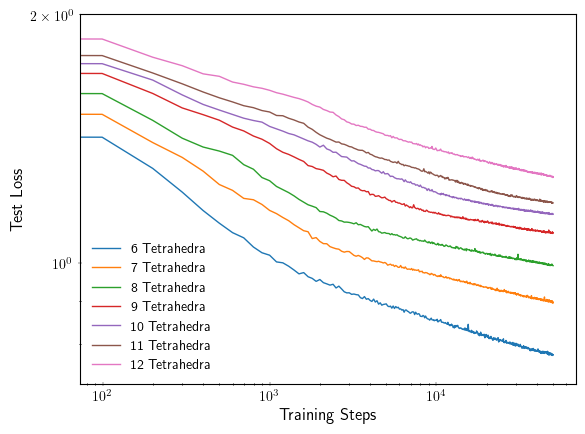

In [249]:
for key in sorted(test_losses.keys()):
    plt.plot(test_losses[key], label=f'{key} Tetrahedra')

plt.xscale('log')
plt.yscale('log')
plt.ylim([None, 2])
plt.xlabel('Training Steps')
plt.ylabel('Test Loss')
plt.legend()
plt.savefig(data_path.parent / 'thesis' / 'figures' / 'sgd_test_losses.pdf', bbox_inches='tight')
plt.show()

In [192]:
dataset = Dataset(file_path, 1_000)
encoder = Encoder(dataset)

### Load Model

In [193]:
vocab_size = len(encoder.char_to_id)
d_model = 64  # Dimension of embeddings and model
num_layers = 6  # Number of transformer blocks
num_heads = 8  # Number of attention heads
seq_len = dataset.max_len + 1  # Sequence length
learning_rate = 0.0005

In [194]:
key = jax.random.PRNGKey(0)
main_key, params_key, dropout_key = jax.random.split(key, 3)

model = Transformer(
    vocab_size=vocab_size,
    d_model=d_model,
    block_size=seq_len,
    num_layers=num_layers,
    num_heads=num_heads,
)

In [195]:
with open(load_path / "params.pkl", "rb") as file:
    params = pickle.load(file)

state = MinimalTrainState.create(
    params=params,
    apply_fn=model.apply,
    dropout_key=dropout_key,
    learning_rate=learning_rate,
    m_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    v_tm1=flax.core.freeze(jax.tree_util.tree_map(jnp.zeros_like, params)),
    t=0,
    tx=optax.adamw(learning_rate=learning_rate, weight_decay=0.01),
)

### Generate Samples

In [196]:
samps_to_gen = 2_000
bos_id = encoder.char_to_id["[BOS]"]
subkey = jax.random.PRNGKey(42)

samps = generate_samples(state, samps_to_gen, seq_len, subkey, bos_id)
samps_str = encoder.decode(np.array(samps))

In [197]:
def check_triangulation(iso_sig):
    try:
        T = regina.engine.Triangulation3.fromIsoSig(iso_sig)
        loads = True
        valid = T.isValid()
        closed = T.isClosed()
        sphere = T.fundamentalGroup().recogniseGroup() == '0'
    except:
        loads = False
        valid = False
        closed = False
        sphere = False

    return loads, valid, closed, sphere

In [198]:
checks = [check_triangulation(iso_sig) for iso_sig in samps_str]
loads = [c[0] for c in checks]
valid = [c[1] for c in checks]
closed = [c[2] for c in checks]
sphere = [c[3] for c in checks]

In [200]:
p_loads = np.sum(loads) / len(loads)
p_valid = np.sum(valid) / len(valid)
p_closed = np.sum(closed) / len(closed)
p_sphere = np.sum(sphere) / len(sphere)

print(f"Loads: {p_loads:.4f}")
print(f"Valid: {p_valid:.4f}")
print(f"Closed: {p_closed:.4f}")
print(f"Sphere: {p_sphere:.4f}")

Loads: 0.0010
Valid: 0.0000
Closed: 0.0000
Sphere: 0.0000


In [201]:
res_dict = {
    "loads": {
        6: 0.1950,
        7: 0.0800,
        8: 0.0430,
        9: 0.0185,
        10: 0.0080,
        11: 0.0075,
        12: 0.0010,
    },
    "valid": {
        6: 0.1950,
        7: 0.0800,
        8: 0.0425,
        9: 0.0185,
        10: 0.0080,
        11: 0.0075,
        12: 0.0000,
    },
    "closed": {
        6: 0.1150,
        7: 0.0390,
        8: 0.0200,
        9: 0.0040,
        10: 0.0025,
        11: 0.0000,
        12: 0.0000,
    },
    "sphere": {
        6: 0.0860,
        7: 0.0235,
        8: 0.0115,
        9: 0.0040,
        10: 0.0010,
        11: 0.0000,
        12: 0.0000,
    },
}

<Axes: >

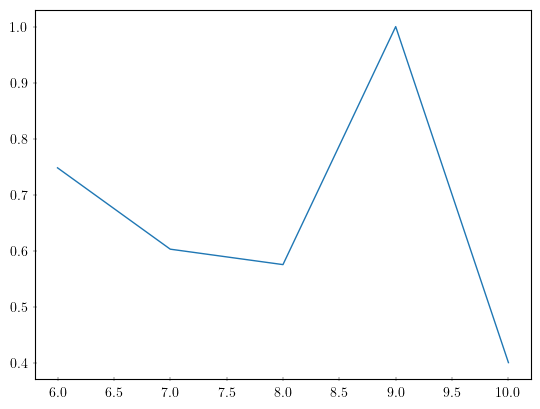

In [261]:
(pd.DataFrame(res_dict)['sphere'] / pd.DataFrame(res_dict)['closed']).plot()

In [255]:
print(pd.DataFrame(res_dict).to_csv().replace(',', '$ & $').replace('\n', ' \\\\\n'))

$ & $loads$ & $valid$ & $closed$ & $sphere \\
6$ & $0.195$ & $0.195$ & $0.115$ & $0.086 \\
7$ & $0.08$ & $0.08$ & $0.039$ & $0.0235 \\
8$ & $0.043$ & $0.0425$ & $0.02$ & $0.0115 \\
9$ & $0.0185$ & $0.0185$ & $0.004$ & $0.004 \\
10$ & $0.008$ & $0.008$ & $0.0025$ & $0.001 \\
11$ & $0.0075$ & $0.0075$ & $0.0$ & $0.0 \\
12$ & $0.001$ & $0.0$ & $0.0$ & $0.0 \\



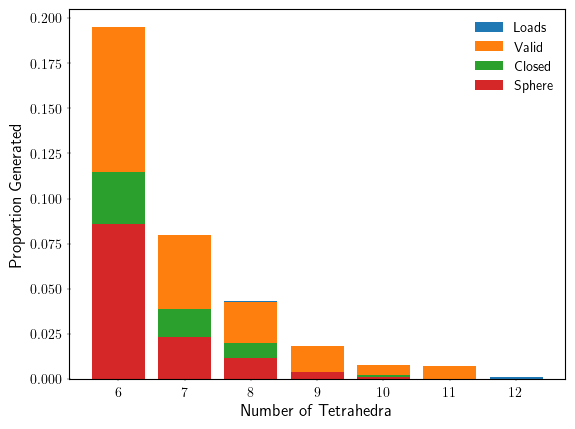

In [ ]:
plt.bar(res_dict['loads'].keys(), res_dict['loads'].values(), label='Loads', color='C0')
plt.bar(res_dict['valid'].keys(), res_dict['valid'].values(), label='Valid', color='C1')
plt.bar(res_dict['closed'].keys(), res_dict['closed'].values(), label='Closed', color='C2')
plt.bar(res_dict['sphere'].keys(), res_dict['sphere'].values(), label='Sphere', color='C3')

plt.xlabel('Number of Tetrahedra')
plt.ylabel('Proportion Generated')

plt.legend()
plt.savefig(data_path.parent / 'thesis' / 'figures' / 'generation_efficiency.pdf', bbox_inches='tight')

plt.show()